In [1]:
!git clone https://github.com/karencfisher/GAN-experiments.git
%cd GAN-experiments

Cloning into 'GAN-experiments'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 25 (delta 8), reused 16 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 2.76 MiB | 19.76 MiB/s, done.
Resolving deltas: 100% (8/8), done.
/content/GAN-experiments


In [2]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torchvision import datasets
from torchvision import transforms
from tqdm import tqdm

from utils import view_samples
from training import train_discriminator, train_generator, make_samples

In [6]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# The previous attempt to download the CelebA dataset failed due to a Google Drive download limit.
# To proceed, you must manually download the 'img_align_celeba.zip' file from:
# https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
# And place it in the 'data/celeba/' directory. After placing the file, torchvision will
# automatically handle the extraction when this cell is executed with 'download=False'.
# celeba_train = datasets.CelebA('data/celeba/', transform=transform, download=False)
celeba_train = datasets.ImageFolder('data/celeba/', transform=transform)
batch_size = 128
num_workers = 4

# build DataLoaders for CIFAR10 dataset
train_loader = torch.utils.data.DataLoader(dataset=celeba_train,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


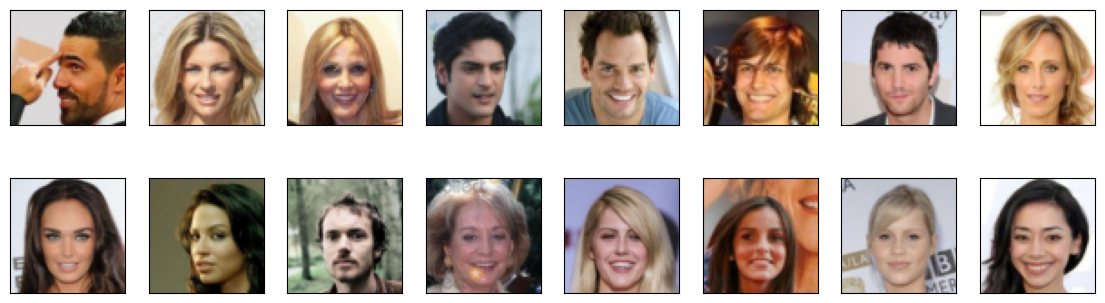

In [7]:
images, _ = next(iter(train_loader))
view_samples(images[:16])

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, use_batch_norm=True):
        super(ConvBlock, self).__init__()
        self.use_batch_norm = use_batch_norm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2,
                              padding = 1, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x) if self.use_batch_norm else x
        return self.activation(x)


class Discriminator(nn.Module):
    def __init__(self, conv_dim=64, channels=3):  # Increased conv_dim
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            ConvBlock(channels, conv_dim, 4, use_batch_norm=False),
            ConvBlock(conv_dim, conv_dim * 2, 4),
            ConvBlock(conv_dim * 2, conv_dim * 4, 4),
            ConvBlock(conv_dim * 4, conv_dim * 8, 4),  # Extra layer

            nn.Flatten(),
            nn.Linear(conv_dim * 8 * 4 * 4, 1)  # Adjusted for 64x64 output
        )

    def forward(self, x):
        return self.discriminator(x)

In [9]:
class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, use_batch_norm=True):
        super(DeconvBlock, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                                         stride, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.deconv(x)
        x = self.batch_norm(x) if self.use_batch_norm else x
        return self.activation(x)

class Generator(nn.Module):
    def __init__(self, latent_dim, conv_dim=64, channels=3):  # Increased conv_dim for higher res
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.generator = nn.Sequential(
            DeconvBlock(latent_dim, conv_dim * 8, 4, 1, 0),  # More layers for 64x64
            DeconvBlock(conv_dim * 8, conv_dim * 4, 4, 2, 1),
            DeconvBlock(conv_dim * 4, conv_dim * 2, 4, 2, 1),
            DeconvBlock(conv_dim * 2, conv_dim, 4, 2, 1),

            nn.ConvTranspose2d(conv_dim, channels, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        if x.dim() == 2:
            x = x.view(x.size(0), self.latent_dim, 1, 1)
        return self.generator(x)

In [10]:
conv_dim = 64  # Increased for higher resolution
latent_dim = 128  # Increase latent dimension for more expressive representations
channels = 3

discriminator = Discriminator(conv_dim, channels)
generator = Generator(latent_dim, conv_dim, channels)

gpu = torch.cuda.is_available()
if gpu:
    discriminator.cuda()
    generator.cuda()

In [11]:
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 15  # Increase from 10 to 50 for better convergence

disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
gen_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

Epoch 1/15: 100%|██████████| 1583/1583 [04:33<00:00,  5.80it/s]


Epoch [1/15], D Loss: 0.6065, G Loss: 3.9472


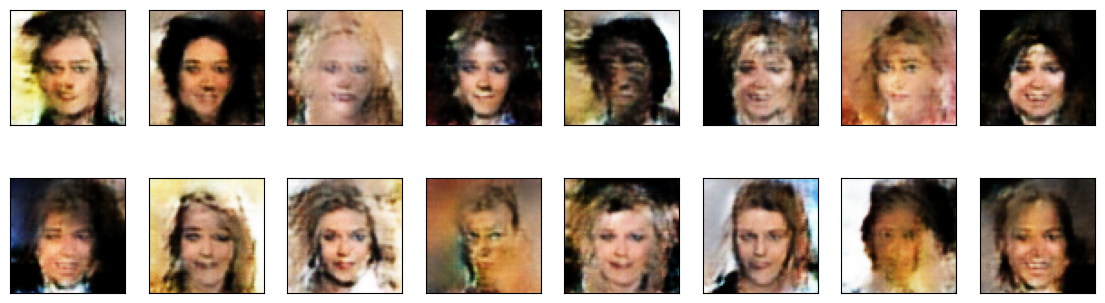

Epoch 2/15: 100%|██████████| 1583/1583 [04:41<00:00,  5.62it/s]


Epoch [2/15], D Loss: 0.4986, G Loss: 2.9082


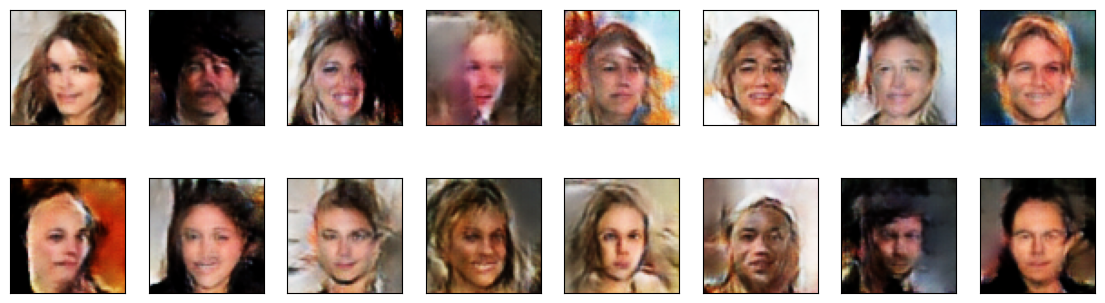

Epoch 3/15: 100%|██████████| 1583/1583 [04:42<00:00,  5.60it/s]


Epoch [3/15], D Loss: 0.5627, G Loss: 3.6891


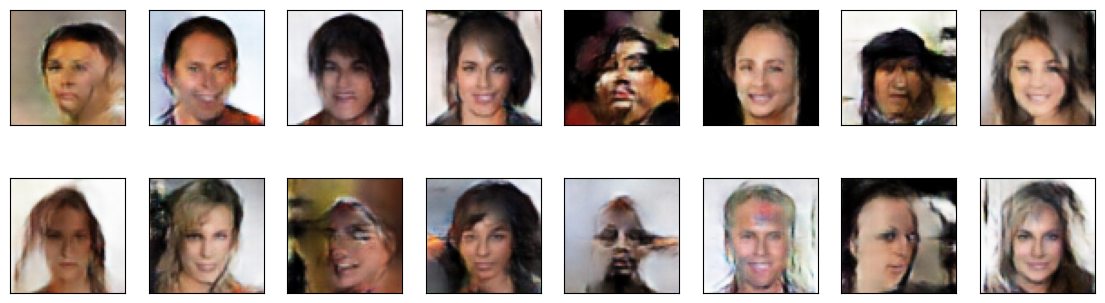

Epoch 4/15: 100%|██████████| 1583/1583 [04:42<00:00,  5.61it/s]


Epoch [4/15], D Loss: 0.4570, G Loss: 2.9943


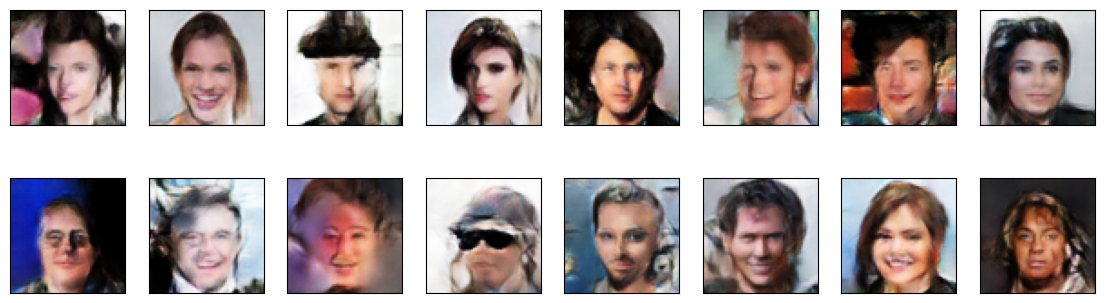

Epoch 5/15: 100%|██████████| 1583/1583 [04:43<00:00,  5.59it/s]


Epoch [5/15], D Loss: 0.6162, G Loss: 2.8101


Epoch 6/15: 100%|██████████| 1583/1583 [04:44<00:00,  5.57it/s]


Epoch [6/15], D Loss: 0.4231, G Loss: 4.2476


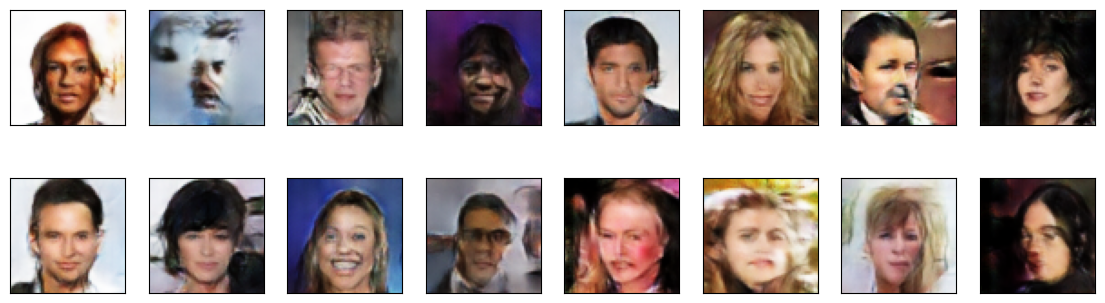

Epoch 7/15: 100%|██████████| 1583/1583 [04:43<00:00,  5.58it/s]


Epoch [7/15], D Loss: 0.4598, G Loss: 3.4420


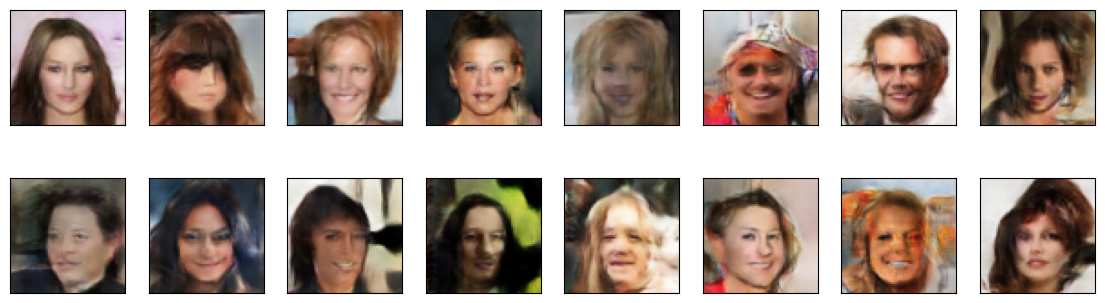

Epoch 8/15: 100%|██████████| 1583/1583 [04:44<00:00,  5.56it/s]


Epoch [8/15], D Loss: 0.5376, G Loss: 2.9738


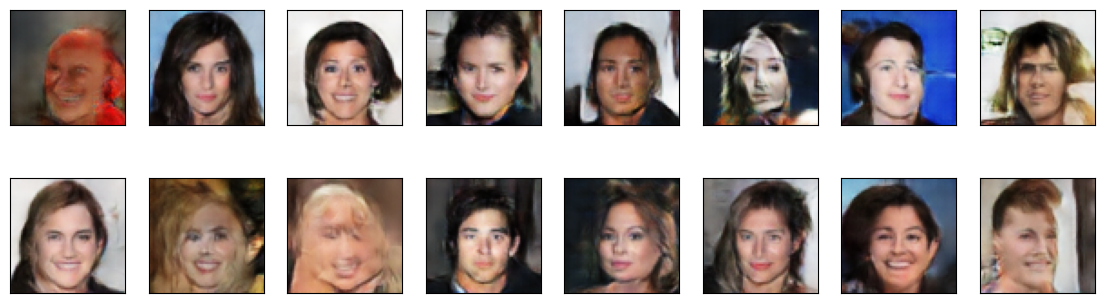

Epoch 9/15: 100%|██████████| 1583/1583 [04:45<00:00,  5.55it/s]


Epoch [9/15], D Loss: 0.8728, G Loss: 3.5700


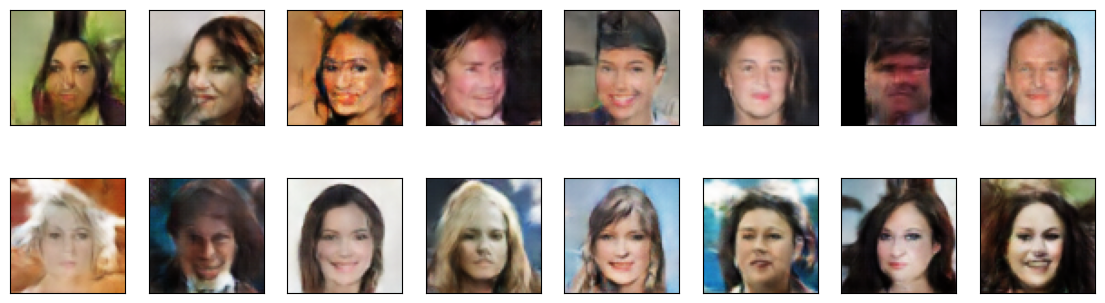

Epoch 10/15: 100%|██████████| 1583/1583 [04:45<00:00,  5.54it/s]


Epoch [10/15], D Loss: 0.6750, G Loss: 4.7359


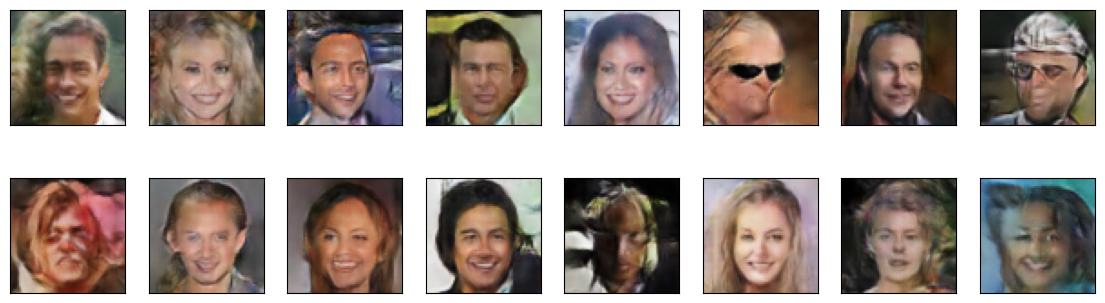

Epoch 11/15: 100%|██████████| 1583/1583 [04:45<00:00,  5.54it/s]


Epoch [11/15], D Loss: 1.2229, G Loss: 7.6960


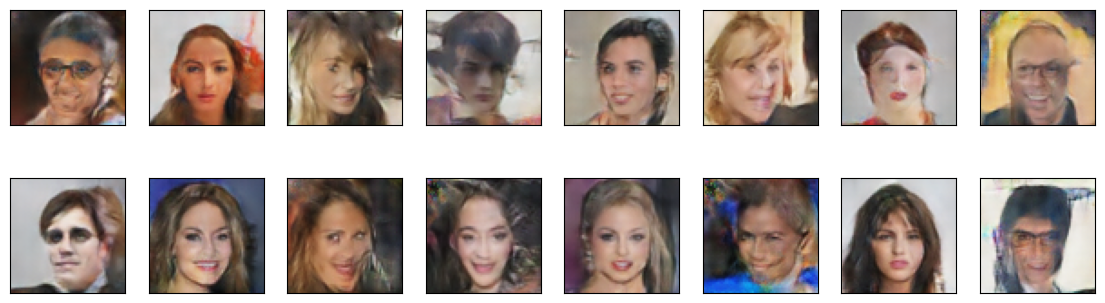

Epoch 12/15: 100%|██████████| 1583/1583 [04:46<00:00,  5.52it/s]


Epoch [12/15], D Loss: 0.4260, G Loss: 4.2723


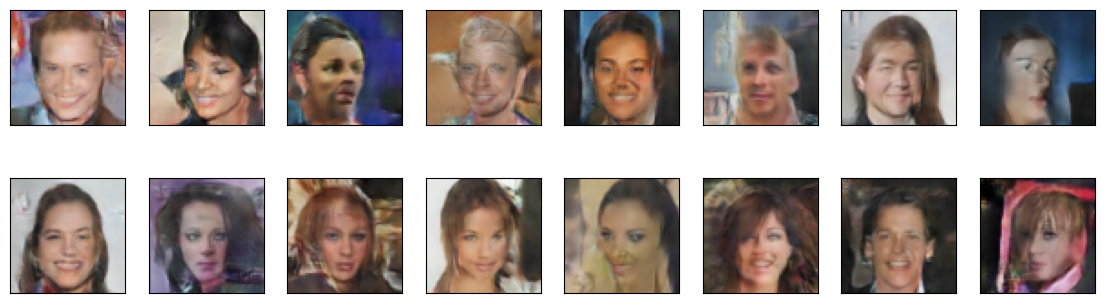

Epoch 13/15: 100%|██████████| 1583/1583 [04:49<00:00,  5.48it/s]


Epoch [13/15], D Loss: 0.6050, G Loss: 2.5099


Epoch 14/15: 100%|██████████| 1583/1583 [04:49<00:00,  5.47it/s]


Epoch [14/15], D Loss: 0.5083, G Loss: 3.0323


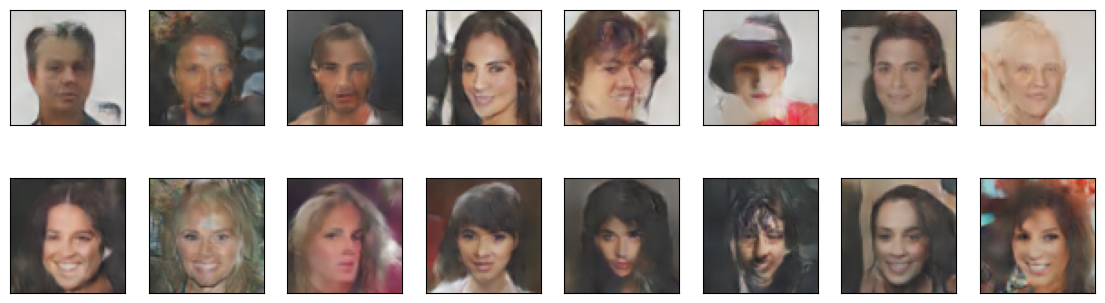

Epoch 15/15: 100%|██████████| 1583/1583 [04:54<00:00,  5.38it/s]


Epoch [15/15], D Loss: 0.5854, G Loss: 3.9485


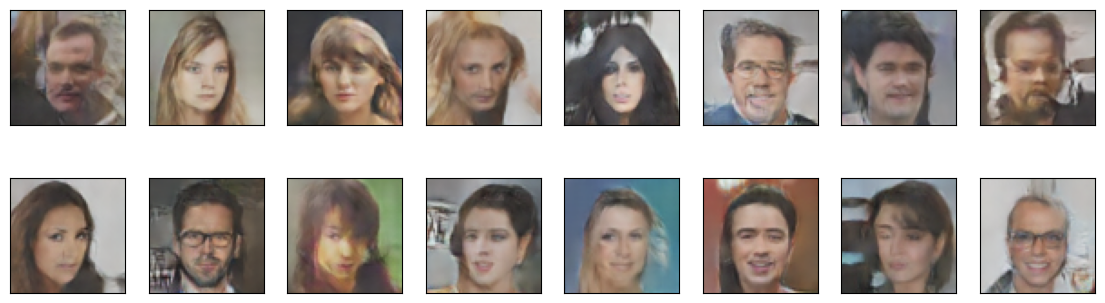

In [12]:
for epoch in range(num_epochs):
    for real_images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_size = real_images.size(0)

        # Train the discriminator
        disc_loss = train_discriminator(real_images, discriminator, disc_optimizer,
                                        generator, latent_dim, gpu)

        # Train the generator
        gen_loss = train_generator(discriminator, generator, gen_optimizer, batch_size,
                                   latent_dim, gpu, channels=3)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"D Loss: {disc_loss:.4f}, G Loss: {gen_loss:.4f}")

    # Generate and view samples
    if (epoch + 1) % 1 == 0:  # Generate samples every 10 epochs to monitor progress
        samples = make_samples(generator, 16, latent_dim, channels=3, gpu=gpu)
        view_samples(samples)